# Проект: вариант 2

## Задание 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. 

Для этого мы применяем метод A/B–тестирования. 

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 

В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
from urllib.error import HTTPError

import numpy as np
import pandas as pd
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

В качестве входных данных Вы имеете 4 csv-файла:

**groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

**groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

**active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

**checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

1) На какие метрики Вы смотрите в ходе анализа и почему?

2) Имеются ли различия в показателях и с чем они могут быть связаны?

3) Являются ли эти различия статистически значимыми?

4) Стоит ли запускать новую механику на всех пользователей?

### Цели, метрики

Хотим увеличить количество покупок => хотим улучшить конвертацию посещений пользователями сайта в покупку => метрика **CR** (conversion rate)

Хотим увеличить средний доход с пользователя => будем смотреть на **средний чек**

### Гипотезы

**H0_CR**: Изменение механики оплаты услуг на сайты значимо не повлияло на **CR**

**H1_CR**: Изменение механики оплаты услуг на сайты значимо повлияло на **CR**

**H0_avg**: Изменение механики оплаты услуг на сайты значимо не повлияло на **средний чек** (различий между средними нет)

**H1_avg**: Изменение механики оплаты услуг на сайты значимо повлияло на **средний чек** (различия между средними есть)

Уровень статистической значимости **p** примем равным **0.05**

Подготовим одну итоговую таблицу для удобного анализа

In [2]:
# df_groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/58Us0DWOzuWAjg')
# df_groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3aARY-P9pfaksg')
# df_active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg')
# df_checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ')

In [3]:
# загрузка данных
df_groups = pd.read_csv('groups.csv', sep=';')
df_groups_add = pd.read_csv('group_add.csv')
df_active_studs = pd.read_csv('active_studs.csv')
df_checks = pd.read_csv('checks.csv', sep=';')

In [4]:
# посмотрим, сколько пользователей относятся к каждой группе
df_groups.groupby('grp', as_index=False).count()

,grp,id
0,A,14671
1,B,59813


In [5]:
# посмотрим, сколько пользователей относятся к каждой группе в дополнительном файле
df_groups_add.groupby('grp', as_index=False).count()

,grp,id
0,A,22
1,B,70


In [6]:
# добавим метку активного пользователя для последующего переноса её в общую таблицу
df_active_studs['active'] = 1

df_active_studs.head(2)

,student_id,active
0,581585,1
1,5723133,1


In [7]:
df_checks.head(2)

,student_id,rev
0,1627,990.0
1,3185,690.0


In [8]:
# посмотрим, есть ли повторяющиеся id студентов - нет
df_checks.nunique()

student_id    541
rev            39
dtype: int64

In [9]:
df_checks.shape

(541, 2)

In [10]:
# создадим итоговую таблицу, для этого добавим дополнительную таблицу с разбивкой на группы к основной
# после чего добавим её к таблице с платежами пользователей, после чего к этому добавим метки активных студентов
data = df_checks.merge(pd.concat([df_groups, df_groups_add]), 
                       left_on='student_id', 
                       right_on='id',
                       how='right') \
                .merge(df_active_studs, left_on='id', right_on='student_id', how='left')

data.head(2)

,student_id_x,rev,id,grp,student_id_y,active
0,NaN,NaN,1489,B,NaN,NaN
1,1627.0,990.0,1627,A,1627.0,1.0


In [11]:
# заполним пропуски нулями и оставим только нужные строки
data = data.fillna(0).drop(columns=['student_id_x', 'student_id_y'])[['id', 'rev', 'grp', 'active']]

data.head(2)

,id,rev,grp,active
0,1489,0.0,B,0.0
1,1627,990.0,A,1.0


In [12]:
data.shape

(74576, 4)

In [13]:
# как видим, из 74576 пользователей лишь 8341 активны
data.active.sum()

8341.0

**data** - общая таблица для анализа, содержащая информацию по каждому пользователю из всех таблиц

Посмотрим, каким кол-вом данных мы обладаем

Нам подходят все активные пользователи, а также все пользователи, которые принесли нам деньги, но по какой-то причине не попали в список активных - возможно баг или что-то, о чём мы не знаем из-за ограниченности информации

In [14]:
data.query("active == 1").shape[0]

8341

In [15]:
data.query("active == 0").shape[0]

66235

In [16]:
# тут всё нормально
data.query("active == 1 and rev > 0").shape[0]

392

In [17]:
# а тут можем заметить странность: активности нет, а оплата есть
data.query("active == 0 and rev > 0").shape[0]

149

In [18]:
data.query("rev > 0").shape[0]

541

In [19]:
# поместим в таблицу data_relevant всех платящих пользователей
data_relevant = data.query("rev > 0")

In [20]:
data_relevant.head(2)

,id,rev,grp,active
1,1627,990.0,A,1.0
39,3185,690.0,B,0.0


Итого, у нас есть **541** платящий пользователь, с которыми мы продолжим работать, вся информация в таблице **data_relevant**

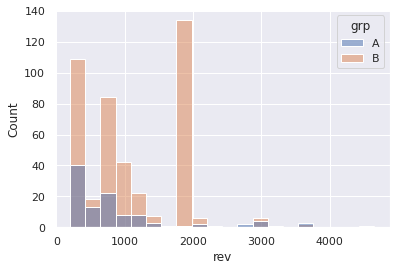

In [21]:
# для понимания с чем работаем
sns.histplot(data=data_relevant, x='rev', hue='grp', bins=20)

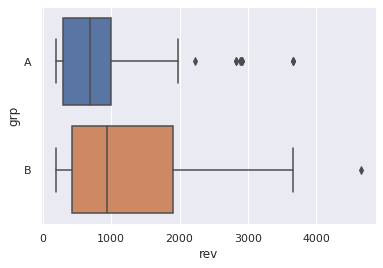

In [22]:
sns.boxplot(data=data_relevant, x='rev', y='grp')

Перейдём непосредственно к CR

In [23]:
# посчитаем метрику CR для каждой группы
# пришлось разбить на дополнительные переменные, тк иначе рекурсивные ошибки
# в pep8 W503 и W503 (как было изначально я закомментил)

# CR_A = (data.query("rev > 0 and grp == 'A'").shape[0] /
#         data.query("grp == 'A' and (rev > 0 or active == 1)").shape[0] * 100)
# CR_B = (data.query("rev > 0 and grp == 'B'").shape[0] /
#         data.query("grp == 'B' and (rev > 0 or active == 1)").shape[0] * 100)

number_of_buyers_A = data.query("rev > 0 and grp == 'A'").shape[0]
number_of_active_A = data.query("grp == 'A' and (rev > 0 or active == 1)").shape[0]

number_of_buyers_B = data.query("rev > 0 and grp == 'B'").shape[0]
number_of_active_B = data.query("grp == 'B' and (rev > 0 or active == 1)").shape[0]

CR_A = number_of_buyers_A / number_of_active_A * 100
CR_B = number_of_buyers_B / number_of_active_B * 100

print('CR_A:', CR_A, '%')
print('CR_B:', CR_B, '%')

CR_A: 6.828334396936822 %
CR_B: 6.268958543983821 %


In [24]:
print(CR_A / CR_B * 100 - 100, '%')

8.922947073718035 %


Как видим, CR_A больше CR_B на **8.92 %** 

Проверим, статистически значимо ли это различие

Для этого воспользуемся хи-квадрат тестом для двух выборок

In [25]:
temp_a = [data.query("rev > 0 and grp == 'A'").shape[0], 
          data.query("rev > 0 and grp == 'B'").shape[0]]
temp_b = [data.query("grp == 'A' and (rev > 0 or active == 1)").shape[0], 
          data.query("grp == 'B' and (rev > 0 or active == 1)").shape[0]]

In [26]:
temp = pd.DataFrame(data=np.array([temp_a, temp_b]))
temp

,0,1
0,107,434
1,1567,6923


In [27]:
stat, p_value, dof, expected = sts.chi2_contingency(pd.DataFrame(np.array([temp_a, temp_b])))

In [28]:
p_value

0.4778925970224768

Полученное значение pvalue > 0.05, значит мы не можем говорить о статистически значимых различиях между CR в этих двух выборках - **не отклоняем** нулевую гипотезу об отсутствии статистически значимых различий в CR **H0_CR**

Проверим, как обстоят дела с средним чеком

Посмотрим, можем ли мы использовать t-тест для проверки нулевой гипотезы о равенстве средних

In [29]:
# разделим таблицу на 2 в зависимости от группы
data_A = data_relevant[data_relevant['grp'] == 'A']
data_B = data_relevant[data_relevant['grp'] == 'B']

In [30]:
# проверим на дисбаланс (просто интересно)
print('A:', data_A.shape[0])
print('B:', data_B.shape[0])

A: 107
B: 434


Проверим данные на нормальность

In [31]:
sts.shapiro(data_A['rev']).pvalue

5.321687643507211e-13

In [32]:
sts.shapiro(data_B['rev']).pvalue

8.947892893418603e-19

Оба распределения не являются нормальными, однако для использования t-теста это не обязательное требование (если размер выборок больше +- 30, у нас больше)

Теперь проверим дисперсии на гомогенность с помощью критерия Левена

In [33]:
sts.levene(data_A['rev'], data_B['rev']).pvalue

0.03477352573759214

pvalue <= 0.05, значит, мы отклоняем нулевую гипотезу о равенстве дисперсий

Итак, на всякий случай мы проверили данные на нормальность (вдруг повезёт - не в этот раз), а также проверили дисперсии в данных на гомогенность (отсутствует), значит, мы не можем использовать t-тест

Можем использовать его непараметрический аналог - U-критерий Манна-Уитни, однако он трудно интерпретируем, тк работает с рангами

Поэтому воспользуемся бутстрэп-анализом по медиане, тк она более устойчивая к выбросам (конечно, богатые покупатели у нас тоже бывают, но их гораздо меньше, чем "обычных", а значит на их фоне сильно выбиваются)

На средние будем смотреть просто ради интереса, чтобы визуально оценить, как сильно они влияют на картину

In [34]:
# посмотрим на средние и медианы в группах
A_mean, B_mean = np.mean(data_A.rev), np.mean(data_B.rev)
A_median, B_median = np.median(data_A.rev), np.median(data_B.rev)

print('A_mean:', np.round(A_mean, 5), 'A_median:', A_median)
print('B_mean:', np.round(B_mean, 5), 'B_median:', B_median)

A_mean: 860.71028 A_median: 690.0
B_mean: 1108.82489 B_median: 935.0


In [35]:
# объявим функцию для бутстрэп-анализа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=10000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95,  # уровень значимости
    visualisation=False  # нужен ли график
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in range(boot_it):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = sts.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    
    p_2 = sts.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    
    p_value = min(p_1, p_2) * 2

    if visualisation:
        plt.hist(pd_boot_data[0], bins=50)

        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()

    return {"ci": ci, 
            "p_value": p_value}

In [36]:
boostrap_result = get_bootstrap(data_A['rev'], data_B['rev'], statistic=np.median)

In [37]:
boostrap_result['ci']

,0
0.025,-400.0
0.975,-109.0


Как видим, 0 не входит в доверительный интервал, значит, различия в медианах есть и они статистически значимые, **принимаем альтернативную гипотезу H1_avg** о значимом различии в среднем чеке

### Общий вывод

Хоть CR в группе B и уменьшился в сравнении с группой A на  8.92 %, это оказалось статистически не значимым изменением.

Другая ситуация с средним чеком: здесь в группе B средний (медианный) чек вырос в сравнении с группой A на 28.83 (35.51) % и это оказалось статистически значимым результатом.

Таким образом, можно сделать вывод, что выкатить изменения в системе оплаты имеет смысл. Однако, по возможности, я бы немного подождал, собрал ещё данных и перепроверил CR.

## Задание 2. SQL

### Задание 2.1

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

Дана таблица **peas**

| Название атрибута | Тип атрибута | Смысловое значение |
| :- | :- | :- |
| st_id | int | ID ученика |
| timest | timestamp | Время решения карточки |
| correct | bool | Правильно ли решена горошина? |
| subject | text | Дисциплина, в которой находится горошина |

In [38]:
# хотел бы я добавить SQL-код как Raw NBConvert,
# но тогда эта ячейка почему-то не отображается в гитлабе
"""
SELECT COUNT(DISTINCT(st_id))
FROM
(
    SELECT 
        st_id, 
        SUM(correct) OVER w AS sum_correct
    FROM 
        peas
    WHERE 
        YEAR(timest) = 2020
        AND MONTH(timest) = 3
    WINDOW w AS
    (
        PARTITION BY st_id
        ORDER BY timest ASC
        RANGE BETWEEN INTERVAL 30 MINUTE PRECEDING AND INTERVAL 30 MINUTE FOLLOWING
    )
) AS t
WHERE sum_correct >= 20
""";

### Задание 2.2

Прибьём таблицы к левому краю (по дефолту по центру)

In [39]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике.

Активными пользователями будем считать пользователей, совершивших не менее 4 попыток решения задач за текущий месяц

Так же в таблице **studs** замечена странность: одному пользователю могут быть присвоены несколько разных меток. Думаю, это какая-то ошибка, поэтому за метку пользователя буду считать первую метку для каждого пользователя в таблице.

Даны таблицы: **peas**,

| Название атрибута | Тип атрибута | Смысловое значение |
| :-: | :-: | :-: |
| st_id | int | ID ученика |
| timest | timestamp | Время решения карточки |
| correct | bool | Правильно ли решена горошина? |
| subject | text | Дисциплина, в которой находится горошина |

**studs**,

| Название атрибута | Тип атрибута | Смысловое значение |
| :-: | :-: | :-: |
| st_id | int | ID ученика |
| test_grp | text  | Метка ученика в данном эксперименте |

и **checks**

| Название атрибута | Тип атрибута | Смысловое значение |
| :-: | :-: | :-: |
| st_id | int | ID ученика |
| sale_time | timestamp | Время покупки |
| money | int | Цена, по которой приобрели данный курс |
| subject | text | Дисциплина, на которую приобрели полный доступ |

In [40]:
# аналогичная хотелка из пункта 2.1
"""
SELECT 
    l_.test_grp_t AS group, 
    l_.ARPU AS ARPU,
    r_.ARPAU AS ARPAU,
    rr_.CR_to_buy AS CR_to_buy,
    rrr_.CR_active_to_buy AS CR_active_to_buy,
    rrrr_.CR_active_math_to_buy_math AS CR_active_math_to_buy_math
FROM
(
    -- ARPU
    
    SELECT test_grp_t, sum_money / uniq_users AS ARPU
    FROM
    (
        SELECT test_grp_t, SUM(money) AS sum_money
        FROM final_project_check AS fin_ch
        LEFT JOIN (
            SELECT st_id, first_value(test_grp) AS test_grp_t
            FROM studs
            GROUP BY st_id
        ) AS temp
        ON fin_ch.st_id = temp.st_id
        GROUP BY test_grp_t
    ) as l
    JOIN 
    (
        SELECT test_grp_t, COUNT(DISTINCT(st_id)) AS uniq_users
        FROM 
        (
            SELECT st_id, first_value(test_grp) AS test_grp_t
            FROM studs
            GROUP BY st_id
        )
        GROUP BY test_grp_t
    ) as r
    ON l.test_grp_t = r.test_grp_t
) as l_
LEFT JOIN
(
    -- ARPAU
    
    SELECT test_grp_t, sum_money / uniq_active_users AS ARPAU
    FROM
    (
        SELECT test_grp_t, SUM(money) AS sum_money
        FROM final_project_check AS fin_ch
        LEFT JOIN (
            SELECT st_id, first_value(test_grp) AS test_grp_t
            FROM studs
            GROUP BY st_id
        ) AS temp
        ON fin_ch.st_id = temp.st_id
        GROUP BY test_grp_t
    ) as l
    JOIN 
    (
        SELECT test_grp_t, COUNT(st_id) AS uniq_active_users
        FROM
        (
            SELECT first_value(test_grp_t) AS test_grp_t, st_id, COUNT(correct) AS number_activities
            FROM peas
            LEFT JOIN (
                SELECT st_id, first_value(test_grp) AS test_grp_t
                FROM studs
                GROUP BY st_id
            ) AS temp
            ON peas.st_id = temp.st_id
            -- можно поставить, если мы хотим смотреть за последний месяц
            -- WHERE toStartOfMonth(timest)  = toStartOfMonth(now())
            GROUP BY st_id
            HAVING number_activities >= 1 -- я бы поставил 4, но тогда в таблице мало что найдётся
        )
        GROUP BY test_grp_t
    ) as r
    ON l.test_grp_t = r.test_grp_t
) as r_
ON l_.test_grp_t = r_.test_grp_t
LEFT JOIN
(
    -- CR_to_buy
    
    SELECT test_grp_t, (uniq_users_fin / uniq_users_st) * 100 AS CR_to_buy
    FROM
    (
        SELECT test_grp_t, COUNT(DISTINCT(st_id)) AS uniq_users_fin
        FROM final_project_check AS fin_ch
        LEFT JOIN (
            SELECT st_id, first_value(test_grp) AS test_grp_t
            FROM studs
            GROUP BY st_id
        ) AS temp
        ON fin_ch.st_id = temp.st_id
        GROUP BY test_grp_t
    ) as l
    JOIN
    (
        SELECT test_grp_t, COUNT(DISTINCT(st_id)) AS uniq_users_st
        FROM (
            SELECT st_id, first_value(test_grp) AS test_grp_t
            FROM studs
            GROUP BY st_id
        )
        GROUP BY test_grp_t
    ) as r
    ON l.test_grp_t = r.test_grp_t
) as rr_
ON l_.test_grp_t = rr_.test_grp_t
LEFT JOIN
(
    -- CR_active_to_buy
    
    SELECT test_grp_t, (uniq_active_users_fin / uniq_active_users) * 100 AS CR_active_to_buy
    FROM
    (
        SELECT test_grp_t, COUNT(peas.st_id) AS uniq_active_users_fin
        FROM
        (
            SELECT first_value(test_grp_t) AS test_grp_t, peas.st_id, COUNT(correct) AS number_activities
            FROM peas
            LEFT JOIN (
                SELECT st_id, first_value(test_grp) AS test_grp_t
                FROM studs
                GROUP BY st_id
            ) AS temp_1
            ON peas.st_id = temp_1.st_id
            LEFT JOIN (
                SELECT st_id, first_value(money) AS money
                FROM final_project_check
                GROUP BY st_id
            ) AS temp_2
            ON peas.st_id = temp_2.st_id
            -- можно поставить, если мы хотим смотреть за последний месяц
            WHERE money > 0 -- AND toStartOfMonth(timest)  = toStartOfMonth(now())
            GROUP BY peas.st_id
            HAVING number_activities >= 1 -- я бы поставил 4, но тогда в таблице мало что найдётся :)
        )
        GROUP BY test_grp_t
    ) as l
    JOIN
    (
        SELECT test_grp_t, COUNT(st_id) AS uniq_active_users
        FROM
        (
            SELECT first_value(test_grp_t) AS test_grp_t, st_id, COUNT(correct) AS number_activities
            FROM peas
            LEFT JOIN (
                SELECT st_id, first_value(test_grp) AS test_grp_t
                FROM studs
                GROUP BY st_id
            ) AS temp
            ON peas.st_id = temp.st_id
            -- можно поставить, если мы хотим смотреть за последний месяц
            -- WHERE toStartOfMonth(timest)  = toStartOfMonth(now())
            GROUP BY st_id
            HAVING number_activities >= 1 -- я бы поставил 4, но тогда в таблице мало что найдётся :)
        )
        GROUP BY test_grp_t
    ) as r
    ON l.test_grp_t = r.test_grp_t
) as rrr_
ON l_.test_grp_t = rrr_.test_grp_t
LEFT JOIN
(
    -- CR_active_math_to_buy_math
    
    SELECT test_grp_t, (uniq_active_users_fin / uniq_active_users AS CR_to_buy) * 100 AS CR_active_math_to_buy_math
    FROM
    (
        SELECT test_grp_t, COUNT(peas.st_id) AS uniq_active_users_fin
        FROM
        (
            SELECT first_value(test_grp_t) AS test_grp_t, peas.st_id, COUNT(correct) AS number_activities
            FROM peas
            LEFT JOIN (
                SELECT st_id, first_value(test_grp) AS test_grp_t
                FROM studs
                GROUP BY st_id
            ) AS temp_1
            ON peas.st_id = temp_1.st_id
            LEFT JOIN (
                SELECT st_id, first_value(money) AS money
                FROM final_project_check
                GROUP BY st_id
            ) AS temp_2
            ON peas.st_id = temp_2.st_id
            -- можно поставить, если мы хотим смотреть за последний месяц
            WHERE money > 0 AND subject = 'Math' -- AND toStartOfMonth(timest)  = toStartOfMonth(now())
            GROUP BY peas.st_id
            HAVING number_activities >= 1 -- я бы поставил 4, но тогда в таблице мало что найдётся :)
        )
        GROUP BY test_grp_t
    ) as l
    JOIN
    (
        SELECT test_grp_t, COUNT(st_id) AS uniq_active_users
        FROM
        (
            SELECT first_value(test_grp_t) AS test_grp_t, st_id, COUNT(correct) AS number_activities
            FROM peas
            LEFT JOIN (
                SELECT st_id, first_value(test_grp) AS test_grp_t
                FROM studs
                GROUP BY st_id
            ) AS temp
            ON peas.st_id = temp.st_id
            -- можно поставить, если мы хотим смотреть за последний месяц
            WHERE subject = 'Math' -- AND toStartOfMonth(timest)
            GROUP BY st_id
            HAVING number_activities >= 1 -- я бы поставил 4, но тогда в таблице мало что найдётся :)
        )
        GROUP BY test_grp_t
    ) as r
    ON l.test_grp_t = r.test_grp_t
) AS rrrr_
ON l_.test_grp_t = rrrr_.test_grp_t
""";

## Задание 3. Python

### Задание 3.1

- Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

- Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [41]:
# в функцию можно как добавлять дополнительную табличку из файла (2 варианта добавления),
# так и не добавлять и просто использовать для пересчёта
def get_metrics(data_f, from_url='', from_path=''):
    
    if from_url != '':
        try:
            data_f_new = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{from_url}')
            print('Данные из файла добавлены успешно\n')
        except HTTPError:
            print('Не могу найти файл, проверьте ссылку')
            return
        
        data_f = pd.concat([data_f, data_f_new]).drop_duplicates().reset_index()
        
    elif from_path != '':
        try:
            data_f_new = pd.read_csv(f'{from_path}')
            print('Данные из файла добавлены успешно\n')
        except OSError:
            print('Не могу найти файл, проверьте путь')
            return
        
        data_f = pd.concat([data_f, data_f_new]).drop_duplicates().reset_index()
    
    df_active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg')
    df_checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ', sep=';')
    
    df_active_studs['active'] = 1

    data_f = df_checks \
        .merge(
            data_f, 
            left_on='student_id', 
            right_on='id',
            how='right') \
        .merge(df_active_studs, left_on='id', right_on='student_id', how='left')

    data_f = data_f \
        .fillna(0) \
        .drop(columns=['student_id_x', 'student_id_y'])[['id', 'rev', 'grp', 'active']]

    data_f_relevant = data_f.query("rev > 0")

    print('--------     CR      --------')

    number_of_buyers_A = data.query("rev > 0 and grp == 'A'").shape[0]
    number_of_active_A = data.query("grp == 'A' and (rev > 0 or active == 1)").shape[0]

    number_of_buyers_B = data.query("rev > 0 and grp == 'B'").shape[0]
    number_of_active_B = data.query("grp == 'B' and (rev > 0 or active == 1)").shape[0]

    CR_A = number_of_buyers_A / number_of_active_A * 100
    CR_B = number_of_buyers_B / number_of_active_B * 100

    print('CR_A:', np.round(CR_A, 5), '%')
    print('CR_B:', np.round(CR_B, 5), '%')
    print('CR одной группы отличается от CR другой на', np.round(CR_A / CR_B * 100 - 100, 5), '%')

    temp_a = [data_f.query("rev > 0 and grp == 'A'").shape[0], 
              data_f.query("rev > 0 and grp == 'B'").shape[0]]
    temp_b = [data_f.query("grp == 'A' and (rev > 0 or active == 1)").shape[0], 
              data_f.query("grp == 'B' and (rev > 0 or active == 1)").shape[0]]

    stat, p_value, dof, expected = sts.chi2_contingency(pd.DataFrame(data=np.array([temp_a, temp_b])))

    if p_value > 0.05:
        print('\nРазличия в CR статистически НЕ ЗНАЧИМЫ')
    else:
        print('\nРазличия в CR статистически ЗНАЧИМЫ')

    print('\n-------- Средний чек --------')

    data_f_A = data_f_relevant[data_f_relevant['grp'] == 'A']
    data_f_B = data_f_relevant[data_f_relevant['grp'] == 'B']

    A_mean, B_mean = np.mean(data_f_A.rev), np.mean(data_f_B.rev)
    A_median, B_median = np.median(data_f_A.rev), np.median(data_f_B.rev)

    print('A_mean:', np.round(A_mean, 5), 'A_median:', A_median)
    print('B_mean:', np.round(B_mean, 5), 'B_median:', B_median)

    boostrap_result_f = get_bootstrap(data_f_A['rev'], data_f_B['rev'], statistic=np.median)

    if 0 in pd.Interval(np.array(boostrap_result_f['ci'])[0][0], np.array(boostrap_result_f['ci'])[1][0]):
        print('\nРазличия в СРЕДНЕМ ЧЕКЕ статистически НЕ ЗНАЧИМЫ')
    else:
        print('\nРазличия в СРЕДНЕМ ЧЕКЕ статистически ЗНАЧИМЫ')
        
    metrics = pd.DataFrame(
        [['A', A_mean, A_median, CR_A],
         ['B', B_mean, B_median, CR_B]],
        columns=['group', 'mean', 'median', 'CR_to_buy']
    )
    
    return metrics

In [42]:
data_test = pd.read_csv('groups.csv', sep=';')

In [43]:
# по желанию можно добавить из новой таблички
metrics = get_metrics(data_test) 

--------     CR      --------
CR_A: 6.82833 %
CR_B: 6.26896 %
CR одной группы отличается от CR другой на 8.92295 %

Различия в CR статистически НЕ ЗНАЧИМЫ

-------- Средний чек --------
A_mean: 860.71028 A_median: 690.0
B_mean: 1106.9977 B_median: 880.0

Различия в СРЕДНЕМ ЧЕКЕ статистически ЗНАЧИМЫ


Теперь перейдём к функции, которая будет строить графики по получаемым метрикам

In [44]:
# табличка, полученная на выходе функции get_metrics()
metrics

,group,mean,median,CR_to_buy
0,A,860.710280,690.0,6.828334
1,B,1106.997699,880.0,6.268959


In [45]:
def grafics_for_metrics(metrics):
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))

    ax[0].set_title("Средние в группах\n", fontsize=16)
    ax[0].set_xlabel("Группа", fontsize=12)        
    ax[0].set_ylabel("Медиана\n", fontsize=12)
    ax[0].bar(metrics['group'], metrics['median'])

    ax[1].set_title("CR в группах\n", fontsize=16)
    ax[1].set_xlabel("Группа", fontsize=12)        
    ax[1].set_ylabel("CR\n", fontsize=12)
    ax[1].bar(metrics['group'], metrics['CR_to_buy'])

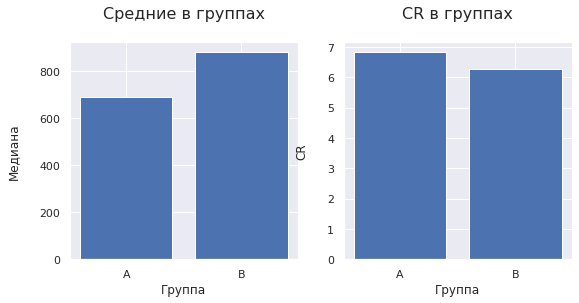

In [46]:
# весьма минималистично :)
grafics_for_metrics(metrics)